In [2]:
import cv2

# Inicializar a webcam (0 para a webcam padrão)
captura = cv2.VideoCapture(0)

if not captura.isOpened():
    print("Erro ao acessar a webcam")
else:
    while True:
        # Ler um frame da webcam
        ret, frame = captura.read()

        if not ret:
            print("Erro ao capturar frame")
            break

        # Exibir o frame capturado
        cv2.imshow('Webcam', frame)

        # Sair do loop quando a tecla 'q' for pressionada
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

# Liberar a captura e fechar as janelas
captura.release()
cv2.destroyAllWindows()


In [ ]:
import cv2
import face_recognition
import numpy as np
import requests
import json

def detect_faces_from_webcam_and_send_to_server(server_url):
    # Carregar o modelo pré-treinado do OpenCV DNN (Caffe model para detecção de rosto)
    net = cv2.dnn.readNetFromCaffe("deploy.prototxt", "res10_300x300_ssd_iter_140000.caffemodel")

    # Capturar a webcam
    video_capture = cv2.VideoCapture(0)

    while True:
        # Capturar frame por frame da webcam
        ret, frame = video_capture.read()
        
        if not ret:
            print("Falha ao capturar imagem da webcam")
            break

        (h, w) = frame.shape[:2]

        # Pré-processar a imagem: redimensionar, normalizar
        blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
        net.setInput(blob)
        detections = net.forward()

        face_locations = []

        # Percorrer as detecções
        for i in range(0, detections.shape[2]):
            confidence = detections[0, 0, i, 2]

            # Filtrar detecções fracas (threshold de confiança pode ser ajustado)
            if confidence > 0.5:
                # Obter as coordenadas da caixa delimitadora para o rosto detectado
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype("int")

                # Adicionar à lista de localizações de rosto
                face_locations.append((startY, endX, endY, startX))

                # Desenhar a caixa delimitadora ao redor do rosto
                cv2.rectangle(frame, (startX, startY), (endX, endY), (0, 255, 0), 2)

        # Verificar se algum rosto foi detectado
        if len(face_locations) > 0:
            # Obter as codificações faciais para os rostos detectados
            face_encodings = face_recognition.face_encodings(frame, face_locations)

            # Preparar os dados para enviar ao servidor
            data_to_send = {
                'encodings': [encoding.tolist() for encoding in face_encodings]  # Converter arrays numpy para listas
            }

            # Enviar as codificações faciais para o servidor
            response = requests.post(server_url, json=data_to_send)

            # Imprimir a resposta do servidor
            print("Resposta do servidor:", response.json())

        # Exibir o frame com rostos detectados
        cv2.imshow("Rostos Detectados", frame)

        # Pressionar 'q' para sair do loop
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Liberar a captura da webcam e fechar as janelas
    video_capture.release()
    cv2.destroyAllWindows()

# Testar a função
server_url = 'http://127.0.0.1:5000/recognize'
detect_faces_from_webcam_and_send_to_server(server_url)


In [19]:
import cv2
import face_recognition
import numpy as np
import requests
import json
import time

def check_server_connection(server_url):
    try:
        # Verifica se o servidor está acessível com uma requisição POST vazia
        response = requests.post(server_url, json={})
        if response.status_code == 400:
            print("Conexão com o servidor bem-sucedida.")
            return True
        else:
            print(f"Falha ao conectar ao servidor: Código de status {response.status_code}")
            return False
    except requests.ConnectionError:
        print("Falha ao conectar ao servidor. Verifique se ele está rodando.")
        return False


def detect_faces_from_webcam_and_send_to_server(server_url):
    # Primeiro, verificamos a conexão com o servidor
    if not check_server_connection(server_url):
        return
    
    # Carregar o modelo pré-treinado do OpenCV DNN (Caffe model para detecção de rosto)
    net = cv2.dnn.readNetFromCaffe("deploy.prototxt", "res10_300x300_ssd_iter_140000.caffemodel")

    # Capturar a webcam
    video_capture = cv2.VideoCapture(0)

    # Verificar se a webcam foi acessada corretamente
    if not video_capture.isOpened():
        print("Não foi possível acessar a webcam.")
        return

    face_detected = False  # Variável para controlar se o rosto foi detectado

    print("Aguardando até que um rosto seja detectado...")

    while not face_detected:
        # Capturar frame por frame da webcam
        ret, frame = video_capture.read()
        
        if not ret:
            print("Falha ao capturar imagem da webcam")
            break

        (h, w) = frame.shape[:2]

        # Pré-processar a imagem: redimensionar, normalizar
        blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
        net.setInput(blob)
        detections = net.forward()

        face_locations = []

        # Percorrer as detecções
        for i in range(0, detections.shape[2]):
            confidence = detections[0, 0, i, 2]

            # Filtrar detecções fracas (threshold de confiança pode ser ajustado)
            if confidence > 0.5:
                # Obter as coordenadas da caixa delimitadora para o rosto detectado
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype("int")

                # Adicionar à lista de localizações de rosto
                face_locations.append((startY, endX, endY, startX))

                # Desenhar a caixa delimitadora ao redor do rosto
                cv2.rectangle(frame, (startX, startY), (endX, endY), (0, 255, 0), 2)

        # Verificar se algum rosto foi detectado
        if len(face_locations) > 0:
            print("Rosto detectado!")
            face_detected = True  # Atualiza o controle para continuar o fluxo

            # Obter as codificações faciais para os rostos detectados
            face_encodings = face_recognition.face_encodings(frame, face_locations)

            # Preparar os dados para enviar ao servidor
            data_to_send = {
                'encodings': [encoding.tolist() for encoding in face_encodings]  # Converter arrays numpy para listas
            }

            # Enviar as codificações faciais para o servidor
            response = requests.post(server_url, json=data_to_send)

            # Imprimir a resposta do servidor
            print("Resposta do servidor:", response.json())

        # Exibir o frame com rostos detectados
        cv2.imshow("Rostos Detectados", frame)

        # Pressionar 'q' para sair do loop, caso necessário
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Liberar a captura da webcam e fechar as janelas
    video_capture.release()
    cv2.destroyAllWindows()

# Testar a função
server_url = 'http://127.0.0.1:5000/recognize'
detect_faces_from_webcam_and_send_to_server(server_url)


Conexão com o servidor bem-sucedida.
Aguardando até que um rosto seja detectado...


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1301: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


In [ ]:
import cv2
import face_recognition
import numpy as np
import requests
import json
import matplotlib.pyplot as plt

def detect_faces_from_webcam_and_send_to_server(server_url):
    # Carregar o modelo pré-treinado do OpenCV DNN (Caffe model para detecção de rosto)
    net = cv2.dnn.readNetFromCaffe("deploy.prototxt", "res10_300x300_ssd_iter_140000.caffemodel")

    # Capturar a webcam
    video_capture = cv2.VideoCapture(0)

    # Verificar se a webcam foi acessada corretamente
    if not video_capture.isOpened():
        print("Não foi possível acessar a webcam.")
        return

    face_detected = False  # Variável para controlar se o rosto foi detectado

    print("Aguardando até que um rosto seja detectado...")

    while not face_detected:
        # Capturar frame por frame da webcam
        ret, frame = video_capture.read()
        
        if not ret:
            print("Falha ao capturar imagem da webcam")
            break

        (h, w) = frame.shape[:2]

        # Pré-processar a imagem: redimensionar, normalizar
        blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
        net.setInput(blob)
        detections = net.forward()

        face_locations = []

        # Percorrer as detecções
        for i in range(0, detections.shape[2]):
            confidence = detections[0, 0, i, 2]

            # Filtrar detecções fracas (threshold de confiança pode ser ajustado)
            if confidence > 0.5:
                # Obter as coordenadas da caixa delimitadora para o rosto detectado
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype("int")

                # Adicionar à lista de localizações de rosto
                face_locations.append((startY, endX, endY, startX))

                # Desenhar a caixa delimitadora ao redor do rosto
                cv2.rectangle(frame, (startX, startY), (endX, endY), (0, 255, 0), 2)

        # Verificar se algum rosto foi detectado
        if len(face_locations) > 0:
            print("Rosto detectado!")
            face_detected = True  # Atualiza o controle para continuar o fluxo

            # Obter as codificações faciais para os rostos detectados
            face_encodings = face_recognition.face_encodings(frame, face_locations)

            # Preparar os dados para enviar ao servidor
            data_to_send = {
                'encodings': [encoding.tolist() for encoding in face_encodings]  # Converter arrays numpy para listas
            }

            # Enviar as codificações faciais para o servidor
            response = requests.post(server_url, json=data_to_send)

            # Imprimir a resposta do servidor
            print("Resposta do servidor:", response.json())

        # Converter a imagem de BGR para RGB (para o matplotlib)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Exibir o frame com rostos detectados usando matplotlib
        plt.imshow(rgb_frame)
        plt.axis('off')  # Esconder os eixos
        plt.show()

        # Pressionar 'q' para sair do loop
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Liberar a captura da webcam e fechar as janelas
    video_capture.release()

# Testar a função
server_url = 'http://127.0.0.1:5000/recognize'
detect_faces_from_webcam_and_send_to_server(server_url)


In [21]:
import cv2
import face_recognition
import numpy as np
import requests
import matplotlib.pyplot as plt

def detect_faces_from_webcam_and_send_to_server(server_url):
    # Carregar o modelo pré-treinado do OpenCV DNN (Caffe model para detecção de rosto)
    net = cv2.dnn.readNetFromCaffe("deploy.prototxt", "res10_300x300_ssd_iter_140000.caffemodel")

    # Capturar a webcam
    video_capture = cv2.VideoCapture(0)

    # Verificar se a webcam foi acessada corretamente
    if not video_capture.isOpened():
        print("Não foi possível acessar a webcam.")
        return

    face_detected = False  # Variável para controlar se o rosto foi detectado

    print("Aguardando até que um rosto seja detectado...")

    while not face_detected:
        # Capturar frame por frame da webcam
        ret, frame = video_capture.read()

        if not ret:
            print("Falha ao capturar imagem da webcam")
            break

        (h, w) = frame.shape[:2]

        # Pré-processar a imagem: redimensionar, normalizar
        blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
        net.setInput(blob)
        detections = net.forward()

        face_locations = []

        # Percorrer as detecções
        for i in range(0, detections.shape[2]):
            confidence = detections[0, 0, i, 2]

            # Filtrar detecções fracas (threshold de confiança pode ser ajustado)
            if confidence > 0.5:
                # Obter as coordenadas da caixa delimitadora para o rosto detectado
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype("int")

                # Adicionar à lista de localizações de rosto
                face_locations.append((startY, endX, endY, startX))

                # Desenhar a caixa delimitadora ao redor do rosto
                cv2.rectangle(frame, (startX, startY), (endX, endY), (0, 255, 0), 2)

        # Verificar se algum rosto foi detectado
        if len(face_locations) > 0:
            print("Rosto detectado!")
            face_detected = True  # Atualiza o controle para continuar o fluxo

            # Mostrar o rosto detectado usando matplotlib
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            plt.imshow(rgb_frame)
            plt.axis('off')
            plt.show()

            # Perguntar ao usuário se deseja enviar a imagem ao servidor
            resposta = input("Deseja enviar este rosto para o servidor? (s/n): ").strip().lower()
            if resposta == 's':
                # Obter as codificações faciais para os rostos detectados
                face_encodings = face_recognition.face_encodings(frame, face_locations)

                # Preparar os dados para enviar ao servidor
                data_to_send = {
                    'encodings': [encoding.tolist() for encoding in face_encodings]  # Converter arrays numpy para listas
                }

                # Enviar as codificações faciais para o servidor
                response = requests.post(server_url, json=data_to_send)

                # Imprimir a resposta do servidor
                print("Resposta do servidor:", response.json())
            else:
                print("Rosto não enviado.")

        # Caso o rosto tenha sido detectado, terminar o loop
        if face_detected:
            break

    # Liberar a captura da webcam
    video_capture.release()

# Testar a função
server_url = 'http://127.0.0.1:5000/recognize'
detect_faces_from_webcam_and_send_to_server(server_url)


Não foi possível acessar a webcam.


In [7]:
import cv2

# Capturar a webcam
video_capture = cv2.VideoCapture(0)

if not video_capture.isOpened():
    print("Não foi possível acessar a webcam.")
else:
    ret, frame = video_capture.read()
    if ret:
        cv2.imshow('Teste de Janela OpenCV', frame)
        cv2.waitKey(0)  # Pressione qualquer tecla para fechar a janela
        cv2.destroyAllWindows()

    video_capture.release()


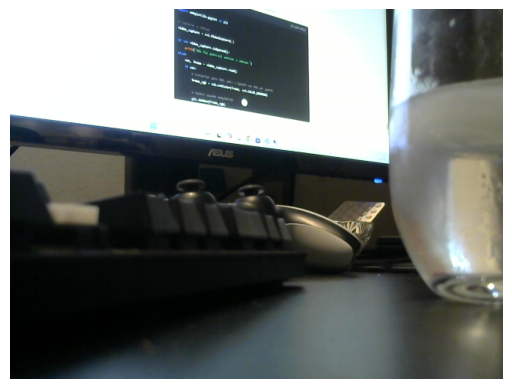

In [3]:
import cv2
import matplotlib.pyplot as plt

# Capturar a webcam
video_capture = cv2.VideoCapture(0)

if not video_capture.isOpened():
    print("Não foi possível acessar a webcam.")
else:
    ret, frame = video_capture.read()
    if ret:
        # Converter para RGB, pois o OpenCV usa BGR por padrão
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Exibir usando matplotlib
        plt.imshow(frame_rgb)
        plt.axis('off')  # Desligar os eixos
        plt.show()  # Mostrar a imagem
        
    video_capture.release()
